In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrand

import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 14}

plt.rc('font', **font)


data = np.genfromtxt("g_A0_good_run.csv", delimiter=",", skip_header=1)
num_samples = data[:, 0]*32*78 
num_muls = data[:, 1]

fig, ax = plt.subplots()
ax.plot(num_samples, num_muls, label="Reward of Vertex Game")
ax.axhline(y=-172., color='r', linestyle='--')
ax.set_xlabel("# samples")
ax.set_ylabel("# multiplications")
ax.set_title("g Optimization with AlphaGrad")

trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,-172., "{:.0f}".format(-172.), color="red", transform=trans, 
        ha="right", va="center")
ax.legend()

In [2]:
import graphax
from graphax import jacve
from graphax.perf import plot_performance
from graphax.examples import f

In [3]:
# 6374 mults
order = [33, 8, 16, 77, 15, 62, 40, 58, 14, 76, 42, 60, 54, 34, 61, 72, 37, 55, 
         18, 75, 36, 74, 65, 26, 35, 25, 66, 38, 64, 59, 53, 20, 27, 47, 10, 69, 
         23, 11, 41, 79, 9, 7, 12, 63, 71, 24, 67, 51, 4, 1, 21, 3, 6, 2, 49, 
         13, 44, 46, 56, 17, 39, 57, 43, 32, 52, 30, 48, 31, 5, 22, 45, 19, 50, 
         28, 29] 

mM_order = [42, 40, 37, 35, 34, 36, 48, 9, 11, 16, 19, 22, 24, 30, 39, 41, 43, 
            46, 52, 55, 56, 57, 60, 67, 3, 6, 13, 17, 25, 27, 31, 45, 50, 51, 
            59, 49, 29, 63, 66, 69, 71, 75, 77, 79, 4, 10, 18, 20, 1, 5, 53, 62, 
            64, 44, 14, 58, 61, 28, 38, 7, 47, 74, 26, 54, 32, 12, 8, 76, 23, 2, 
            33, 15, 72, 21, 65]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 : 32
SparseTensor: 
   shape = (4, 1, 4, 4),
   out_dims = (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=1, val_dim=1)),
   primal_dims = (DenseDimension(id=2, size=4, val_dim=2), DenseDimension(id=3, size=4, val_dim=3)),
   val = Traced<ShapedArray(float32[4,1,4,4])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []
 SparseTensor: 
   shape = (4, 1, 4, 4),
   out_dims = (SparseDimension(id=0, size=4, val_dim=0, other_id=3), DenseDimension(id=1, size=1, val_dim=1)),
   primal_dims = (DenseDimension(id=2, size=4, val_dim=2), SparseDimension(id=3, size=4, val_dim=0, other_id=0)),
   val = Traced<ShapedArray(float32[4,1,4])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []

[1, 1, 1, 1] [1, 1, 1, 1] (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=1, val_dim=1), DenseDimension(id=2, size=4, val_dim=2), DenseDimension(id=3, size=4, val_dim=3))
2 : 192
3 : 80
4 : 160
5 : 24
6 : 4
Spar

  0%|          | 0/1000 [00:00<?, ?it/s]

79 : 0
77 : 64
76 : 80
75 : 0
74 : 512
72 : 512
71 : 0
SparseTensor: 
   shape = (4, 4, 4, 4),
   out_dims = (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=4, val_dim=1)),
   primal_dims = (DenseDimension(id=2, size=4, val_dim=2), DenseDimension(id=3, size=4, val_dim=3)),
   val = Traced<ShapedArray(float32[4,4,4,4])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []
 SparseTensor: 
   shape = (4, 4, 4, 4),
   out_dims = (DenseDimension(id=0, size=4, val_dim=0), SparseDimension(id=1, size=4, val_dim=1, other_id=3)),
   primal_dims = (DenseDimension(id=2, size=4, val_dim=2), SparseDimension(id=3, size=4, val_dim=1, other_id=1)),
   val = Traced<ShapedArray(float32[4,1,4])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []

[1, 1, 1, 1] [1, 1, 1, 1] (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=4, val_dim=1), DenseDimension(id=2, size=4, val_dim=2), DenseDimension(id=3, size=4, val_

  0%|          | 0/1000 [00:00<?, ?it/s]

42 : 0
40 : 0
37 : 0
35 : 0
34 : 0
36 : 0
48 : 0
9 : 0
11 : 0
16 : 16
19 : 6
22 : 6
24 : 4
30 : 6
39 : 6
41 : 4
43 : 12
46 : 3
52 : 1
55 : 4
56 : 1
57 : 1
60 : 4
67 : 4
3 : 32
6 : 4
13 : 6
17 : 8
25 : 8
27 : 0
31 : 0
45 : 8
50 : 24
51 : 128
59 : 4
49 : 12
29 : 18
63 : 4
66 : 16
69 : 16
71 : 0
75 : 0
77 : 64
79 : 0
4 : 20
SparseTensor: 
   shape = (4, 1, 1),
   out_dims = (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=1, val_dim=1)),
   primal_dims = (DenseDimension(id=2, size=1, val_dim=2),),
   val = Traced<ShapedArray(float32[4,1,1])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []
 SparseTensor: 
   shape = (4, 1, 1),
   out_dims = (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=1, val_dim=1)),
   primal_dims = (DenseDimension(id=2, size=1, val_dim=2),),
   val = Traced<ShapedArray(float32[4,1,1])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []

[1, 1, 1] [1, 1, 1] (DenseDim

  0%|          | 0/1000 [00:00<?, ?it/s]

33 : 12
8 : 40
16 : 16
77 : 64
15 : 48
62 : 32
40 : 0
58 : 8
14 : 0
76 : 80
42 : 0
60 : 4
54 : 32
34 : 0
61 : 0
72 : 80
37 : 0
55 : 4
18 : 8
75 : 0
36 : 0
74 : 768
65 : 240
26 : 8
35 : 0
25 : 8
66 : 36
38 : 12
64 : 4
SparseTensor: 
   shape = (4, 4, 4),
   out_dims = (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=4, val_dim=1)),
   primal_dims = (DenseDimension(id=2, size=4, val_dim=2),),
   val = Traced<ShapedArray(float32[4,4,4])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []
 SparseTensor: 
   shape = (4, 4, 4),
   out_dims = (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=4, val_dim=1)),
   primal_dims = (DenseDimension(id=2, size=4, val_dim=2),),
   val = Traced<ShapedArray(float32[4,4,4])>with<DynamicJaxprTrace(level=1/0)>,
   pre_transforms = []
   post_transforms = []

[1, 1, 1] [1, 1, 1] (DenseDimension(id=0, size=4, val_dim=0), DenseDimension(id=1, size=4, val_dim=1), DenseDimension(id=2, size=4, val

100%|██████████| 1000/1000 [00:00<00:00, 1203.52it/s]


fwd mean: 0.04460766538977623, rev mean: 0.0383000448346138, mM mean: 0.05570279806852341, cc mean: 0.03724760562181473
fwd err: [-0.00083925  0.00261857], rev err: [-0.00095263  0.00101208], mM err: [-0.00117898  0.00131131], cc err: [-0.00092232  0.00105462]


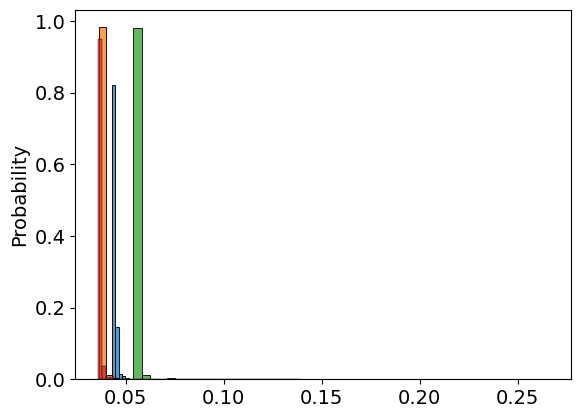

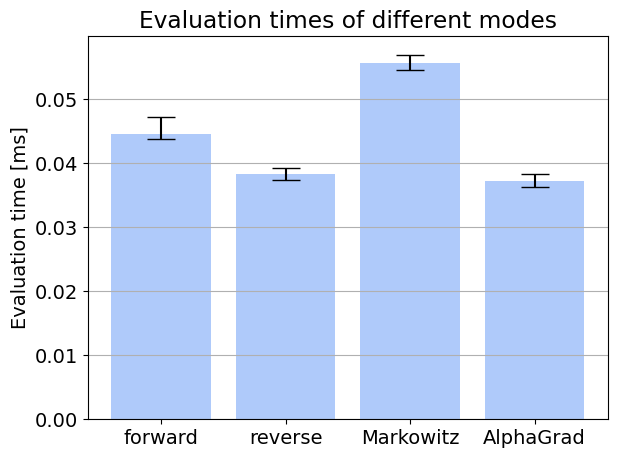

In [5]:
shape = (600,)
key = jrand.PRNGKey(250197)
a = jrand.uniform(key, (4,))
b = jrand.uniform(key, (2, 3))
c = jrand.uniform(key, (4, 4))
d = jrand.uniform(key, (4, 1))
xs = (a, b, c, d)
xs = jax.device_put(xs, jax.devices("cpu")[0])
plot_performance(f, xs, order, mM_order, "./f.png", samplesize=1000, use_vmap=False)

### Best result so far
fwd mean: 3.8236873149871826, rev mean: 3.6495230197906494, cc_mean: 2.9825470447540283, mM_mean: 3.825319290161133
fwd std: 0.2087354212999344, rev std: 0.39476415514945984, cc_std: 0.6004145741462708, mM_std: 0.47684094309806824

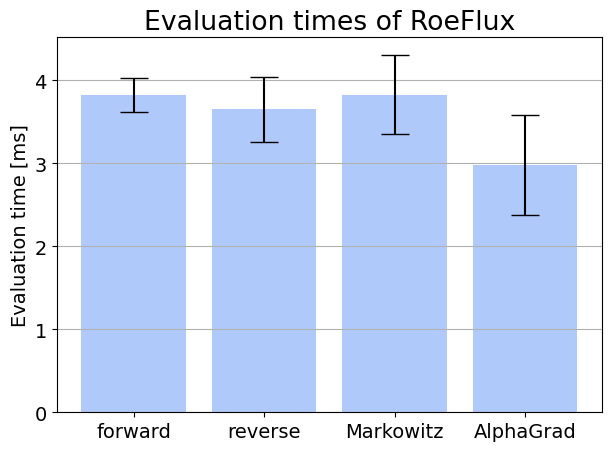

In [ ]:
# Order: fwd, rev, mM, cc
means = jnp.array([3.8236873149871826, 3.6495230197906494, 3.825319290161133, 2.9825470447540283])
stds = jnp.array([0.2087354212999344, 0.39476415514945984, 0.47684094309806824, 0.6004145741462708])
x_pos = jnp.arange(len(means))
modes = ["forward", "reverse", "Markowitz", "AlphaGrad"]


fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align="center", alpha=0.5, 
            ecolor="black", color="#6096f6", capsize=10)
    
ax.set_ylabel("Evaluation time [ms]", fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(modes, fontsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_title(f"Evaluation times of HumanHeartDipole")
ax.yaxis.grid(True)  
# ax.set_ylim((0.025, 0.04))

plt.tight_layout()